# Data Pre-Processing

### Import packages

In [1230]:
import pandas as pd
import os
from io import StringIO
import re


### Chose Instance and prep

In [1231]:
# # Flight disruptions
# data_folder = 'Data/A01_6088570'
# data_folder = 'Data/A02_6088570'
# data_folder = 'Data/A03_6088570'

# # Flight and Airport disruptions
# data_folder = 'Data/A04_6088570'

# # Airport disruptions
# data_folder = 'Data/A05_6088570'


# # Example Instances
# data_folder = 'Data/PoC-scenario'
# data_folder = 'Data/Example-scenario'
# data_folder = 'Data/Example-scenario-2'
data_folder = 'Data/Example-scenario-3'




# Function to read a CSV file, skip comment lines starting with '%', and stopping at lines starting with '#'
def read_csv_with_comments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter out comment lines and stop at the ending line
    data_lines = []
    for line in lines:
        if line.startswith('#'):
            break
        if not line.startswith('%'):
            data_lines.append(line.strip())

    # Check if data_lines is empty
    if len(data_lines) == 0:
        return None  # Return None if the file has no data

    return data_lines


# Data files
aircraft_file = data_folder + '/aircraft.csv'
airports_file = data_folder + '/airports.csv'
alt_aircraft_file = data_folder + '/alt_aircraft.csv'
alt_airports_file = data_folder + '/alt_airports.csv'
alt_flights_file = data_folder + '/alt_flights.csv'
config_file = data_folder + '/config.csv'
dist_file = data_folder + '/dist.csv'
flights_file = data_folder + '/flights.csv'
itineraries_file = data_folder + '/itineraries.csv'
positions_file = data_folder + '/position.csv'
rotations_file = data_folder + '/rotations.csv'



### Preparation

## Each file has its own format

### Config file

In [1232]:
# Function to convert config file lines to a dictionary with corresponding values
def parse_config(data_lines):
    config_dict = {}
    config_dict['RecoveryPeriod'] = {
        'StartDate': data_lines[0].split()[0],
        'StartTime': data_lines[0].split()[1],
        'EndDate': data_lines[0].split()[2],
        'EndTime': data_lines[0].split()[3]
    }

    def parse_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 3):
            costs.append({'Cabin': parts[i], 'Type': parts[i+1], 'Cost': float(parts[i+2])})
        return costs

    config_dict['DelayCosts'] = parse_costs(data_lines[1])
    config_dict['CancellationCostsOutbound'] = parse_costs(data_lines[2])
    config_dict['CancellationCostsInbound'] = parse_costs(data_lines[3])

    def parse_downgrading_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 4):
            costs.append({'FromCabin': parts[i], 'ToCabin': parts[i+1], 'Type': parts[i+2], 'Cost': float(parts[i+3])})
        return costs

    config_dict['DowngradingCosts'] = parse_downgrading_costs(data_lines[4])
    config_dict['PenaltyCosts'] = [float(x) for x in re.split(r'\s+', data_lines[5])]
    config_dict['Weights'] = [float(x) for x in re.split(r'\s+', data_lines[6])]
    return config_dict

# Read the config file and parse the data
config_lines = read_csv_with_comments(config_file)
if config_lines:
    config_dict = parse_config(config_lines)
    # print(config_dict)
else:
    # give error
    print('Config file is empty')

### Airports file

In [1233]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_airports(data_lines):
    airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        capacities = []
        for i in range(1, len(parts), 4):
            capacities.append({
                'Dep/h': int(parts[i]),
                'Arr/h': int(parts[i+1]),
                'StartTime': parts[i+2],
                'EndTime': parts[i+3]
            })
        airports_dict[airport] = capacities
    return airports_dict


airports_lines = read_csv_with_comments(airports_file)
if airports_lines:
    airports_dict = parse_airports(airports_lines)
    # print(airports_dict)
else:
    airports_dict = None



### Distance file

In [1234]:
# Function to convert dist file lines to a dictionary with corresponding values
def parse_dist(data_lines):
    dist_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        origin = parts[0]
        destination = parts[1]
        dist = int(parts[2])
        type_ = parts[3]
        dist_dict[(origin, destination)] = {'Dist': dist, 'Type': type_}
    return dist_dict



dist_lines = read_csv_with_comments(dist_file)
if dist_lines:
    dist_dict = parse_dist(dist_lines)
    # print(dist_dict)
else:
    dist_dict = None

### Flights file

In [1235]:
# Function to convert flights file lines to a dictionary with corresponding values
def parse_flights(data_lines):
    flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        flights_dict[flight] = {
            'Orig': parts[1],
            'Dest': parts[2],
            'DepTime': parts[3],
            'ArrTime': parts[4],
            'PrevFlight': int(parts[5])
        }
    return flights_dict


flights_lines = read_csv_with_comments(flights_file)
if flights_lines:
    flights_dict = parse_flights(flights_lines)
    # print(flights_dict)
else:
    flights_dict = None


### Aircraft file

In [1236]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_aircraft(data_lines):
    aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        aircraft_dict[aircraft] = {
            'Model': parts[1],
            'Family': parts[2],
            'Config': parts[3],
            'Dist': int(parts[4]),
            'Cost/h': float(parts[5]),
            'TurnRound': int(parts[6]),
            'Transit': int(parts[7]),
            'Orig': parts[8],
            'Maint': parts[9] if len(parts) > 9 else None
        }
    return aircraft_dict

aircraft_lines = read_csv_with_comments(aircraft_file)
if aircraft_lines:
    aircraft_dict = parse_aircraft(aircraft_lines)
    # print(aircraft_dict)
else:
    aircraft_dict = None
    
print(len(aircraft_dict))
print(aircraft_dict)


3
{'B767#1': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'CDG', 'Maint': 'CDG-10/01/08-06:00-10/01/08-10:00-20'}, 'B767#2': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'BKK', 'Maint': 'NULL'}, 'B767#3': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'BKK', 'Maint': 'NULL'}}


### Rotations file

In [1237]:
# Function to convert rotations file lines to a dictionary with corresponding values
def parse_rotations(data_lines):
    rotations_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        rotations_dict[flight] = {
            'DepDate': parts[1],
            'Aircraft': parts[2]
        }
    return rotations_dict

rotations_lines = read_csv_with_comments(rotations_file)
if rotations_lines:
    rotations_dict = parse_rotations(rotations_lines)
    # print(rotations_dict)
else:
    rotations_dict = None


### Itineraries file

In [1238]:
# Function to convert itineraries file lines to a dictionary with corresponding values
def parse_itineraries(data_lines):
    itineraries_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        ident = int(parts[0])
        itineraries_dict[ident] = {
            'Type': parts[1],
            'Price': float(parts[2]),
            'Count': int(parts[3]),
            'Flights': parts[4:]
        }
    return itineraries_dict

itineraries_lines = read_csv_with_comments(itineraries_file)
if itineraries_lines:
    itineraries_dict = parse_itineraries(itineraries_lines)
    # print(itineraries_dict)
else:
    itineraries_dict = None



### Positions file

In [1239]:
# Function to convert positions file lines to a dictionary with corresponding values
def parse_positions(data_lines):
    positions_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        model = parts[1]
        config = parts[2]
        count = int(parts[3])
        if airport not in positions_dict:
            positions_dict[airport] = []
        positions_dict[airport].append({'Model': model, 'Config': config, 'Count': count})
    return positions_dict


positions_lines = read_csv_with_comments(positions_file)
if positions_lines:
    positions_dict = parse_positions(positions_lines)
    # print(positions_dict)
else:
    positions_dict = None


    


### Flights disruptions file

In [1240]:
# Function to convert flight disruptions file lines to a dictionary with corresponding values
def parse_alt_flights(data_lines):
    alt_flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        alt_flights_dict[flight] = {
            'DepDate': parts[1],
            'Delay': int(parts[2])
        }
    return alt_flights_dict

alt_flights_lines = read_csv_with_comments(alt_flights_file)
if alt_flights_lines:
    alt_flights_dict = parse_alt_flights(alt_flights_lines)
    # print(alt_flights_dict)
else:
    alt_flights_dict = None




### Aircraft disruptions file

In [1241]:
# Function to convert aircraft disruptions file lines to a dictionary with corresponding values
def parse_alt_aircraft(data_lines):
    alt_aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        alt_aircraft_dict[aircraft] = {
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4]
        }
    return alt_aircraft_dict

alt_aircraft_lines = read_csv_with_comments(alt_aircraft_file)
if alt_aircraft_lines:
    alt_aircraft_dict = parse_alt_aircraft(alt_aircraft_lines)
    # print(alt_aircraft_dict)
else:
    alt_aircraft_dict = None



### Airport disruptions file

In [1242]:
# Function to convert airport disruptions file lines to a dictionary with corresponding values
def parse_alt_airports(data_lines):
    alt_airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        if airport not in alt_airports_dict:
            alt_airports_dict[airport] = []
        alt_airports_dict[airport].append({
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4],
            'Dep/h': int(parts[5]),
            'Arr/h': int(parts[6])
        })
    return alt_airports_dict

alt_airports_lines = read_csv_with_comments(alt_airports_file)
if alt_airports_lines:
    alt_airports_dict = parse_alt_airports(alt_airports_lines)
    # print(alt_airports_dict)
else:
    alt_airports_dict = None


print(alt_airports_dict)

None


In [1243]:
# print the distance from cdg to lhr
# print(dist_dict[('CDG', 'LHR')])
print(flights_dict)
print(len(flights_dict))
print(flights_dict)

{1: {'Orig': 'CDG', 'Dest': 'BKK', 'DepTime': '10:00', 'ArrTime': '13:00', 'PrevFlight': 0}, 2: {'Orig': 'CDG', 'Dest': 'BKK', 'DepTime': '12:50', 'ArrTime': '16:00', 'PrevFlight': 0}, 3: {'Orig': 'BKK', 'Dest': 'CDG', 'DepTime': '10:00', 'ArrTime': '12:00', 'PrevFlight': 0}}
3
{1: {'Orig': 'CDG', 'Dest': 'BKK', 'DepTime': '10:00', 'ArrTime': '13:00', 'PrevFlight': 0}, 2: {'Orig': 'CDG', 'Dest': 'BKK', 'DepTime': '12:50', 'ArrTime': '16:00', 'PrevFlight': 0}, 3: {'Orig': 'BKK', 'Dest': 'CDG', 'DepTime': '10:00', 'ArrTime': '12:00', 'PrevFlight': 0}}


In [1244]:
# merge all the data into a single dictionary with the keys as the file names
data_dict = {
    'config': config_dict,              # this is the config data with the costs and weights
    'aircraft': aircraft_dict,          # this is the aircraft data with the aircrafts
    'airports': airports_dict,          # this is the airport data with the airports
    'dist': dist_dict,                  # this is the distance data with the distances
    'flights': flights_dict,            # this is the flight data with the flights
    'rotations': rotations_dict,        # this is the rotation data with the rotations
    'itineraries': itineraries_dict,    # this is the itinerary data with the itineraries
    'positions': positions_dict,        # this is the position data with the positions
    'alt_flights': alt_flights_dict,    # this is the flight disruption data with the flight disruptions
    'alt_aircraft': alt_aircraft_dict,  # this is the aircraft disruption data with the aircraft disruptions
    'alt_airports': alt_airports_dict   # this is the airport disruption data with the airport disruptions
}

# print the structure of the data dictionary by printing the keys, and the keys inside the keys etc
print("All the keys in data_dict")
for key in data_dict:
    print(key)
    if data_dict[key] is not None:
        for sub_key in data_dict[key]:
            print(f'  {sub_key}')
            # only print the first 3 sub_sub_keys
            if isinstance(data_dict[key][sub_key], dict):
                for sub_sub_key in data_dict[key][sub_key]:
                    print(f'    {sub_sub_key}')
    print()





All the keys in data_dict
config
  RecoveryPeriod
    StartDate
    StartTime
    EndDate
    EndTime
  DelayCosts
  CancellationCostsOutbound
  CancellationCostsInbound
  DowngradingCosts
  PenaltyCosts
  Weights

aircraft
  B767#1
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#2
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#3
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint

airports
  BKK
  CDG

dist
  ('BKK', 'CDG')
    Dist
    Type
  ('CDG', 'BKK')
    Dist
    Type

flights
  1
    Orig
    Dest
    DepTime
    ArrTime
    PrevFlight
  2
    Orig
    Dest
    DepTime
    ArrTime
    PrevFlight
  3
    Orig
    Dest
    DepTime
    ArrTime
    PrevFlight

rotations
  1
    DepDate
    Aircraft
  2
    DepDate
    Aircraft
  3
    DepDate
    Aircraft

itineraries
  1
    Type
    Price
    Count
    Flights
  2
    Type

In [1245]:
print(config_dict)
# print(aircraft_dict['B767#1'])
# print the flight disruptions
print(alt_flights_dict)
# print(flights_dict)

{'RecoveryPeriod': {'StartDate': '02/02/24', 'StartTime': '10:00', 'EndDate': '02/02/24', 'EndTime': '20:00'}, 'DelayCosts': [{'Cabin': 'F', 'Type': 'D', 'Cost': 0.75}, {'Cabin': 'F', 'Type': 'C', 'Cost': 1.08}, {'Cabin': 'F', 'Type': 'I', 'Cost': 1.5}, {'Cabin': 'B', 'Type': 'D', 'Cost': 0.5}, {'Cabin': 'B', 'Type': 'C', 'Cost': 0.75}, {'Cabin': 'B', 'Type': 'I', 'Cost': 1.0}, {'Cabin': 'E', 'Type': 'D', 'Cost': 0.33}, {'Cabin': 'E', 'Type': 'C', 'Cost': 0.5}, {'Cabin': 'E', 'Type': 'I', 'Cost': 0.66}], 'CancellationCostsOutbound': [{'Cabin': 'F', 'Type': 'D', 'Cost': 1000.0}, {'Cabin': 'F', 'Type': 'C', 'Cost': 2000.0}, {'Cabin': 'F', 'Type': 'I', 'Cost': 3000.0}, {'Cabin': 'B', 'Type': 'D', 'Cost': 650.0}, {'Cabin': 'B', 'Type': 'C', 'Cost': 1300.0}, {'Cabin': 'B', 'Type': 'I', 'Cost': 2000.0}, {'Cabin': 'E', 'Type': 'D', 'Cost': 350.0}, {'Cabin': 'E', 'Type': 'C', 'Cost': 650.0}, {'Cabin': 'E', 'Type': 'I', 'Cost': 1000.0}], 'CancellationCostsInbound': [{'Cabin': 'F', 'Type': 'D', 

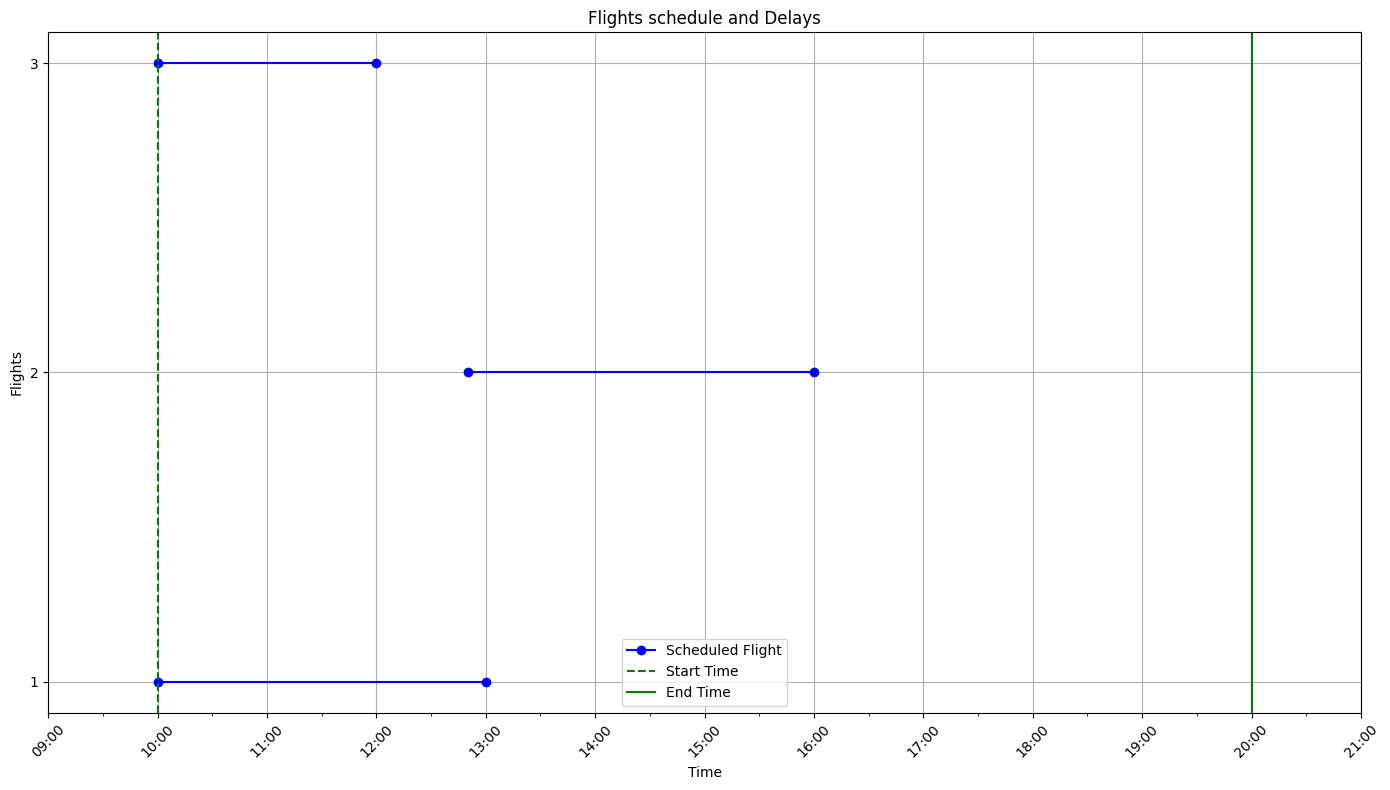

In [1246]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from flight_id to index
flight_ids = list(flights_dict.keys())
flight_indices = {flight_id: index + 1 for index, flight_id in enumerate(flight_ids)}

# Plot each flight's schedule in blue
for flight_id, flight_info in flights_dict.items():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    ax.plot([dep_datetime, arr_datetime], [flight_indices[flight_id], flight_indices[flight_id]], color='blue', marker='o', label='Scheduled Flight' if flight_id == 1 else "")

# Plot disruptions in red
if alt_flights_dict:
    for flight_id, disruption_info in alt_flights_dict.items():
        if flight_id in flights_dict:
            dep_datetime_str = flights_dict[flight_id]['DepTime']
            dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
            delay_duration = timedelta(minutes=disruption_info['Delay'])
            delayed_datetime = dep_datetime + delay_duration

            ax.plot([dep_datetime, delayed_datetime], [flight_indices[flight_id], flight_indices[flight_id]], color='red', linestyle='--', label='Delay of Flight' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(dep_datetime, flight_indices[flight_id], 'rx', label='Disruption Start' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(delayed_datetime, flight_indices[flight_id], 'rx', label='Disruption End' if flight_id == list(alt_flights_dict.keys())[0] else "")

# Formatting the plot
# xlim is earliest_datetime - 1 hour and latest_datetime + 1 hour
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Time')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Time')

# Setting the y-ticks to be the indices with corresponding flight IDs as labels
plt.yticks(range(1, len(flights_dict) + 1), flight_ids)

plt.xlabel('Time')
plt.ylabel('Flights')
plt.title('Flights schedule and Delays')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()

plt.show()


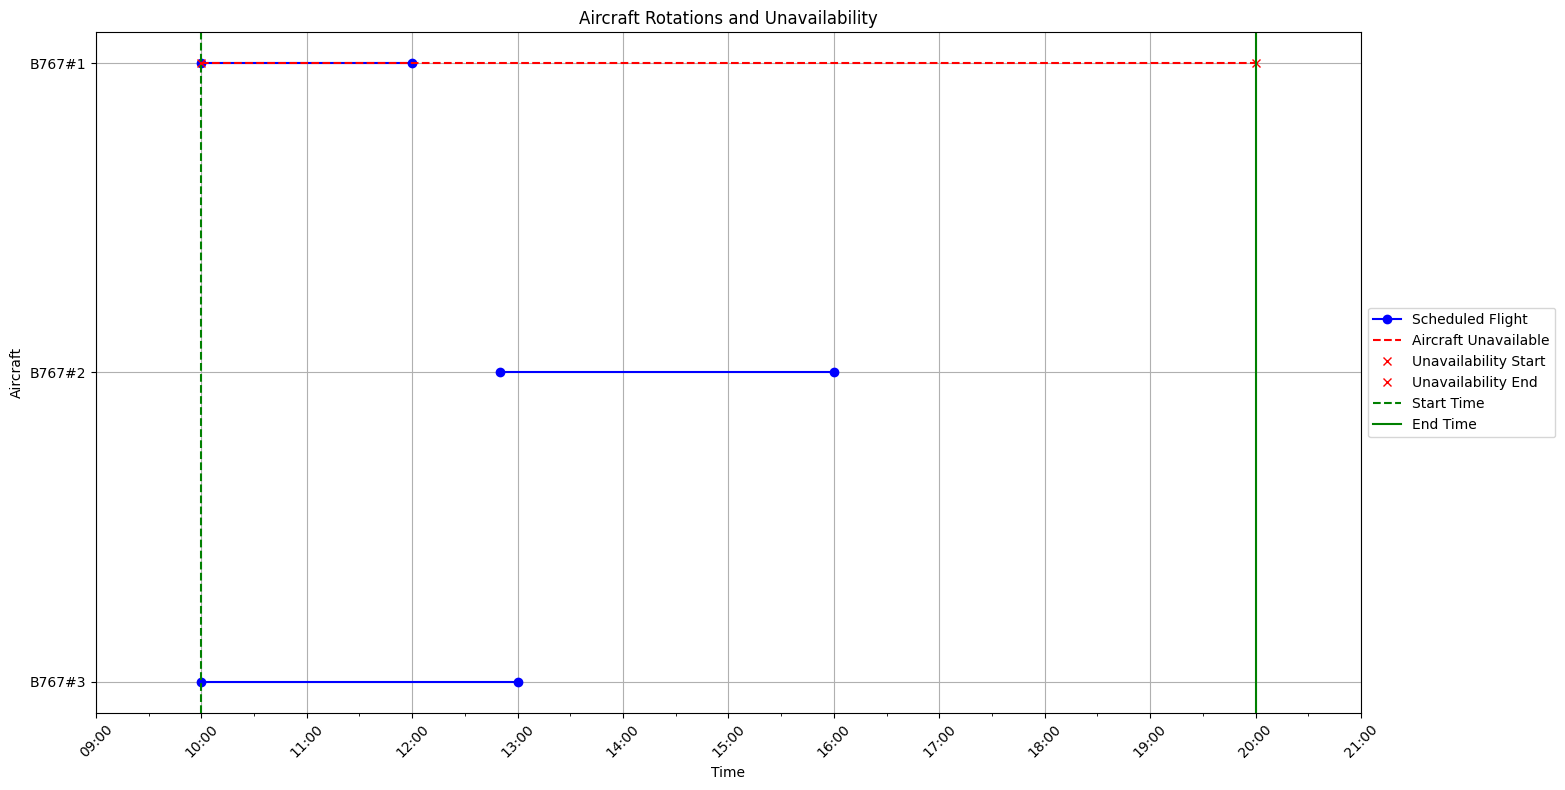

In [1247]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from aircraft to index
aircraft_ids = sorted(list(set([rotation_info['Aircraft'] for rotation_info in rotations_dict.values()])), reverse=True)
aircraft_indices = {aircraft_id: index + 1 for index, aircraft_id in enumerate(aircraft_ids)}

# Plot each flight's schedule based on aircraft in blue
for rotation_id, rotation_info in rotations_dict.items():
    flight_id = rotation_id
    aircraft_id = rotation_info['Aircraft']
    
    if flight_id in flights_dict:
        flight_info = flights_dict[flight_id]
        dep_datetime_str = flight_info['DepTime']
        arr_datetime_str = flight_info['ArrTime']
        
        dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
        arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
        
        ax.plot([dep_datetime, arr_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='blue', marker='o', label='Scheduled Flight' if rotation_id == 1 else "")

# Plot disruptions in red for flight delays
if alt_flights_dict:
    for flight_id, disruption_info in alt_flights_dict.items():
        if flight_id in flights_dict:
            dep_datetime_str = flights_dict[flight_id]['DepTime']
            dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
            delay_duration = timedelta(minutes=disruption_info['Delay'])
            delayed_datetime = dep_datetime + delay_duration
            
            aircraft_id = rotations_dict[flight_id]['Aircraft']  # Get the aircraft ID for the flight
            ax.plot([dep_datetime, delayed_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Delay of Flight' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(dep_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption Start' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(delayed_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption End' if flight_id == list(alt_flights_dict.keys())[0] else "")

# Plot unavailability in red for aircraft
if alt_aircraft_dict:
    for aircraft_id, unavailability_info in alt_aircraft_dict.items():
        start_date = unavailability_info['StartDate']
        start_time = unavailability_info['StartTime']
        end_date = unavailability_info['EndDate']
        end_time = unavailability_info['EndTime']
        
        unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
        
        ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Aircraft Unavailable' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability Start' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability End' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")

# Formatting the plot
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Time')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Time')

# Setting the y-ticks to be the indices with corresponding aircraft IDs as labels
plt.yticks(range(1, len(aircraft_ids) + 1), aircraft_ids)

plt.xlabel('Time')
plt.ylabel('Aircraft')
plt.title('Aircraft Rotations and Unavailability')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Create legend on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [1248]:
print(aircraft_dict)

{'B767#1': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'CDG', 'Maint': 'CDG-10/01/08-06:00-10/01/08-10:00-20'}, 'B767#2': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'BKK', 'Maint': 'NULL'}, 'B767#3': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'BKK', 'Maint': 'NULL'}}


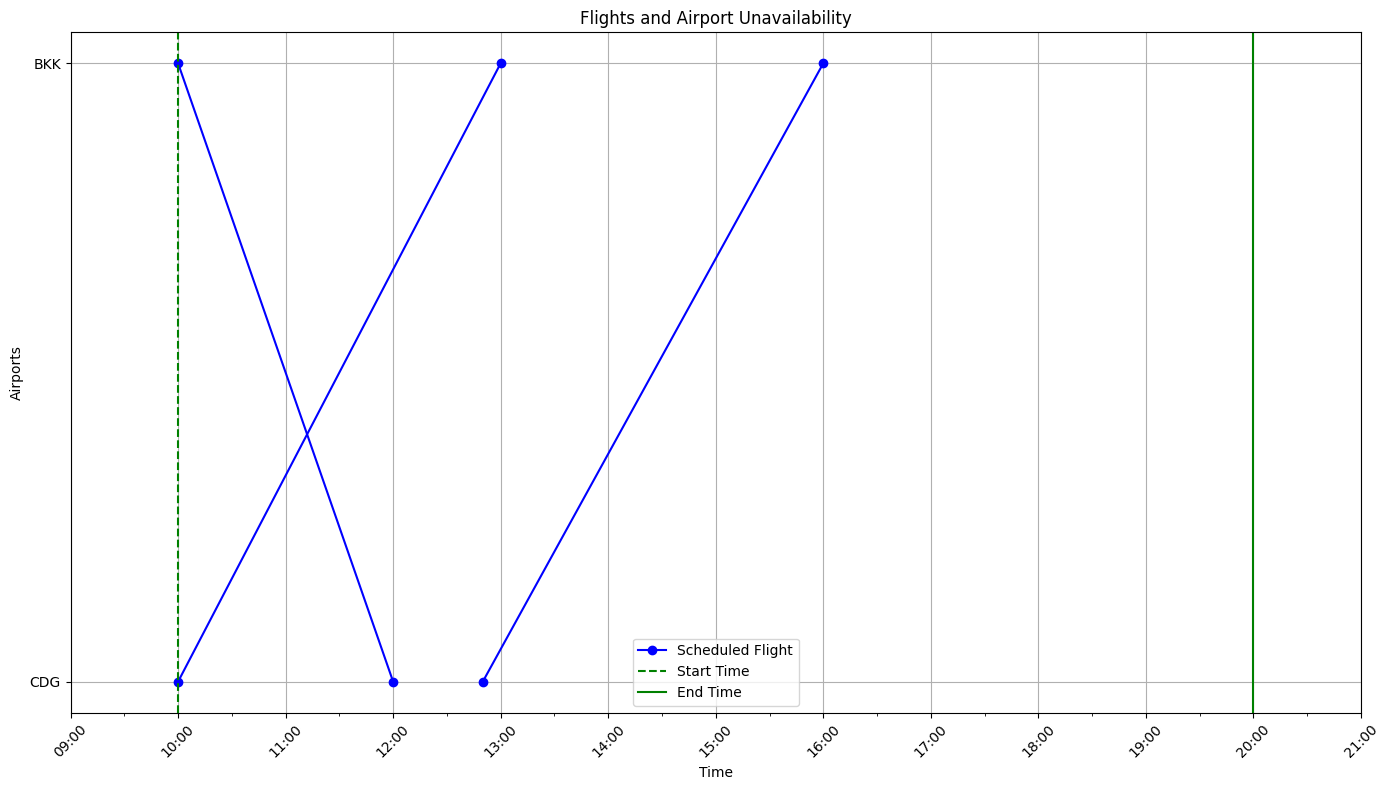

In [1249]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from airports to index
airports = list(set([flight_info['Orig'] for flight_info in flights_dict.values()] + [flight_info['Dest'] for flight_info in flights_dict.values()]))
airport_indices = {airport: index + 1 for index, airport in enumerate(airports)}

# Plot each flight's schedule based on airports in blue
for flight_id, flight_info in flights_dict.items():
    orig_airport = flight_info['Orig']
    dest_airport = flight_info['Dest']
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    ax.plot([dep_datetime, arr_datetime], [airport_indices[orig_airport], airport_indices[dest_airport]], color='blue', marker='o', label='Scheduled Flight' if flight_id == 1 else "")

# Track which labels have been added to the legend
labels_added = set()

# Plot airport disruptions with different styles
if alt_airports_dict:
    for airport, disruptions in alt_airports_dict.items():
        for disruption_info in disruptions:
            start_date = disruption_info['StartDate']
            start_time = disruption_info['StartTime']
            end_date = disruption_info['EndDate']
            end_time = disruption_info['EndTime']
            dep_h = disruption_info['Dep/h']
            arr_h = disruption_info['Arr/h']
            
            unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
            unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

            if dep_h == 0 and arr_h == 0:
                linestyle = 'solid'
                linewidth = 3
                label = 'Completely Closed'
            elif dep_h == 0 or arr_h == 0:
                linestyle = 'solid'
                linewidth = 1
                label = 'Partially Closed (Dep/Arr)'
            else:
                linestyle = 'dashed'
                linewidth = 1
                label = 'Constrained'
            
            # Only add each label once
            if label not in labels_added:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth, label=label)
                labels_added.add(label)
            else:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth)
            ax.plot(unavail_start_datetime, airport_indices[airport], 'rx')
            ax.plot(unavail_end_datetime, airport_indices[airport], 'rx')

# Formatting the plot
# xlim is earliest_datetime - 1 hour and latest_datetime + 1 hour
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Time')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Time')

# Setting the y-ticks to be the indices with corresponding airport codes as labels
plt.yticks(range(1, len(airport_indices) + 1), airport_indices.keys())

plt.xlabel('Time')
plt.ylabel('Airports')
plt.title('Flights and Airport Unavailability')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()

plt.show()


# Reinforcement Learning

## Environment

In [1250]:
# Creating environment
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class AircraftDisruptionEnv(gym.Env):
    def __init__(self, aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict):
        super(AircraftDisruptionEnv, self).__init__()
        
        # Start and end time of the recovery period (first hour)
        start_date = config_dict['RecoveryPeriod']['StartDate']
        start_time = config_dict['RecoveryPeriod']['StartTime']
        self.start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        self.end_datetime = self.start_datetime + timedelta(hours=1)
        
        self.aircraft_ids = list(aircraft_dict.keys())
        self.state_space_size = len(self.aircraft_ids)
        
        # State space: [has_flight, is_available] for each aircraft
        self.observation_space = spaces.Dict({
            aircraft_id: spaces.MultiBinary(2) for aircraft_id in self.aircraft_ids
        })
        
        # Action space: index of the aircraft to reassign (0 to number of aircraft)
        self.full_action_space = spaces.Discrete(self.state_space_size + 1)  # +1 for "no action"
        self.action_space = self.full_action_space  # Initialize with the full action space
        
        # Store flights, rotations, and disruption data
        self.aircraft_dict = aircraft_dict
        self.flights_dict = flights_dict
        self.rotations_dict = rotations_dict
        self.alt_aircraft_dict = alt_aircraft_dict
        

        # Tracking environment-delaed flights
        self.environment_delayed_flights = {}  # {flight_id: delay_minutes}
        
        # Initialize state
        self.state = self._get_initial_state(rotations_dict, flights_dict, alt_aircraft_dict, self.start_datetime, self.end_datetime)
        
        # Store swapped flights for later analysis (to be adjusted in rotations_dict)
        self.swapped_flights = []

    def _get_initial_state(self, rotations_dict, flights_dict, alt_aircraft_dict, start_time, end_time):
        state = {}
        
        for aircraft_id in self.aircraft_ids:
            # Check if the aircraft has a flight assigned in the first hour
            has_flight = False
            for rotation_id, rotation_info in rotations_dict.items():
                flight_info = flights_dict[rotation_id]
                dep_time = parse_time_with_day_offset(flight_info['DepTime'], start_time)
                arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)
                
                if rotation_info['Aircraft'] == aircraft_id and dep_time < end_time and arr_time > start_time:
                    has_flight = True
                    break
            
            # Check if the aircraft is available in the first hour
            is_available = True
            if aircraft_id in alt_aircraft_dict:
                unavailability_info = alt_aircraft_dict[aircraft_id]
                unavail_start_time = datetime.strptime(unavailability_info['StartDate'] + ' ' + unavailability_info['StartTime'], '%d/%m/%y %H:%M')
                unavail_end_time = datetime.strptime(unavailability_info['EndDate'] + ' ' + unavailability_info['EndTime'], '%d/%m/%y %H:%M')
                    
                if unavail_start_time < end_time and unavail_end_time > start_time:
                    is_available = False
            
            # Assign the state for the current aircraft
            state[aircraft_id] = np.array([1 if has_flight else 0, 1 if is_available else 0], dtype=np.int8)
        
        return state

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"
        
        if action == 0 or (action > 0 and np.array_equal(self.state[self.aircraft_ids[action - 1]], [1, 0])):
            # No action taken or action is the same as the conflicting aircraft
            print("No action taken or action is the same as the conflicting aircraft")
            reward = self._calculate_reward(self.state)
            done = self._is_done(self.state)
            return self.state, reward, done, False, {}
        
        # Take the action (tail swap)
        selected_aircraft_id = self.aircraft_ids[action - 1]
        for aircraft_id in self.aircraft_ids:
            if np.array_equal(self.state[aircraft_id], [1, 0]):  # Find the conflicting aircraft, where is assigned yes but is available no
                self.state[aircraft_id][0] = 0  # Remove the flight from the conflicted aircraft
                self.state[selected_aircraft_id][0] = 1  # Assign the flight to the selected aircraft
                
                # Track the specific flights being swapped
                conflicting_flight_id = next(
                    rotation_id for rotation_id, rotation_info in self.rotations_dict.items()
                    if rotation_info['Aircraft'] == aircraft_id and self._flight_in_time_window(rotation_id, self.start_datetime, self.end_datetime)
                )
                self.swapped_flights.append((conflicting_flight_id, selected_aircraft_id))  # storing the swap with flight ID and which aircraft takes over
                print(f"Swapped flight {conflicting_flight_id} from Aircraft {aircraft_id} to Aircraft {selected_aircraft_id}")
                
                # Check for scheduling conflicts with the selected aircraft
                for other_rotation_id, other_rotation_info in self.rotations_dict.items():
                    if other_rotation_info['Aircraft'] == selected_aircraft_id:
                        other_flight_info = self.flights_dict[other_rotation_id]
                        other_dep_time = parse_time_with_day_offset(other_flight_info['DepTime'], self.start_datetime)
                        other_arr_time = parse_time_with_day_offset(other_flight_info['ArrTime'], other_dep_time)
                        
                        conflicting_flight_info = self.flights_dict[conflicting_flight_id]
                        conf_dep_time = parse_time_with_day_offset(conflicting_flight_info['DepTime'], self.start_datetime)
                        conf_arr_time = parse_time_with_day_offset(conflicting_flight_info['ArrTime'], conf_dep_time)
                        
                        # If there is a time conflict, delay the other flight
                        if other_dep_time < conf_arr_time and other_arr_time > conf_dep_time:
                            # Delay the other flight to start after the conflicting flight's arrival time
                            delay_duration = conf_arr_time - other_dep_time
                            delay_minutes = int(delay_duration.total_seconds() // 60)
                            new_dep_time = other_dep_time + delay_duration
                            new_arr_time = other_arr_time + delay_duration
                            
                            self.flights_dict[other_rotation_id]['DepTime'] = new_dep_time.strftime('%H:%M')
                            self.flights_dict[other_rotation_id]['ArrTime'] = new_arr_time.strftime('%H:%M')
                            self.environment_delayed_flights[other_rotation_id] = delay_minutes  # Track the delayed flight and its delay duration
                            print(f"Delayed flight {other_rotation_id} by {delay_minutes} minutes to {new_dep_time.strftime('%H:%M')} - {new_arr_time.strftime('%H:%M')}")
                break
        
        reward = self._calculate_reward(self.state)
        done = self._is_done(self.state)
        
        return self.state, reward, done, False, {}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, self.start_datetime, self.end_datetime)
        self.swapped_flights = []  # Reset the swapped flights list
        return self.state, {}

    def _calculate_reward(self, state):
        conflicts = sum(1 for status in state.values() if np.array_equal(status, [1, 0]))
        delay_penalty = sum(self.environment_delayed_flights.values())
        return -1000 * conflicts - delay_penalty
    
    def _is_done(self, state):
        return all(not np.array_equal(status, [1, 0]) for status in state.values())

    def _flight_in_time_window(self, flight_id, start_time, end_time):
        flight_info = self.flights_dict[flight_id]
        dep_time = parse_time_with_day_offset(flight_info['DepTime'], start_time)
        arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)
        return dep_time < end_time and arr_time > start_time

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)



# AGENT

### Random agent

In [1251]:

# Create the environment
env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)

# Reset the environment
initial_state, _ = env.reset(seed=0)
print("Initial state:", initial_state)

# Print possible actions
print("Possible actions:", [action for action in range(env.action_space.n)])

# Take a random action
action = 1
state, reward, done, _, _ = env.step(action)  # Unpack the 5th value as well
print("Action taken:", action)
print("State after action:", state)
print("Reward:", reward)
print("Done:", done)

print("Swapped flights:", env.swapped_flights)

Initial state: {'B767#1': array([1, 0], dtype=int8), 'B767#2': array([0, 1], dtype=int8), 'B767#3': array([1, 1], dtype=int8)}
Possible actions: [0, 1, 2, 3]
No action taken or action is the same as the conflicting aircraft
Action taken: 1
State after action: {'B767#1': array([1, 0], dtype=int8), 'B767#2': array([0, 1], dtype=int8), 'B767#3': array([1, 1], dtype=int8)}
Reward: -1000
Done: False
Swapped flights: []


### RL AGENT

In [1252]:
############################################################################################################

# RESULT VISUALIZATION 

Swapped Flights: []
Environment Delayed Flights: {}
Updated Rotations Dict: {1: {'DepDate': '02/02/2024', 'Aircraft': 'B767#3'}, 2: {'DepDate': '02/02/2024', 'Aircraft': 'B767#2'}, 3: {'DepDate': '02/02/2024', 'Aircraft': 'B767#1'}}
Aircraft Indices: {'B767#3': 1, 'B767#2': 2, 'B767#1': 3}
Plotting unavailability for B767#1


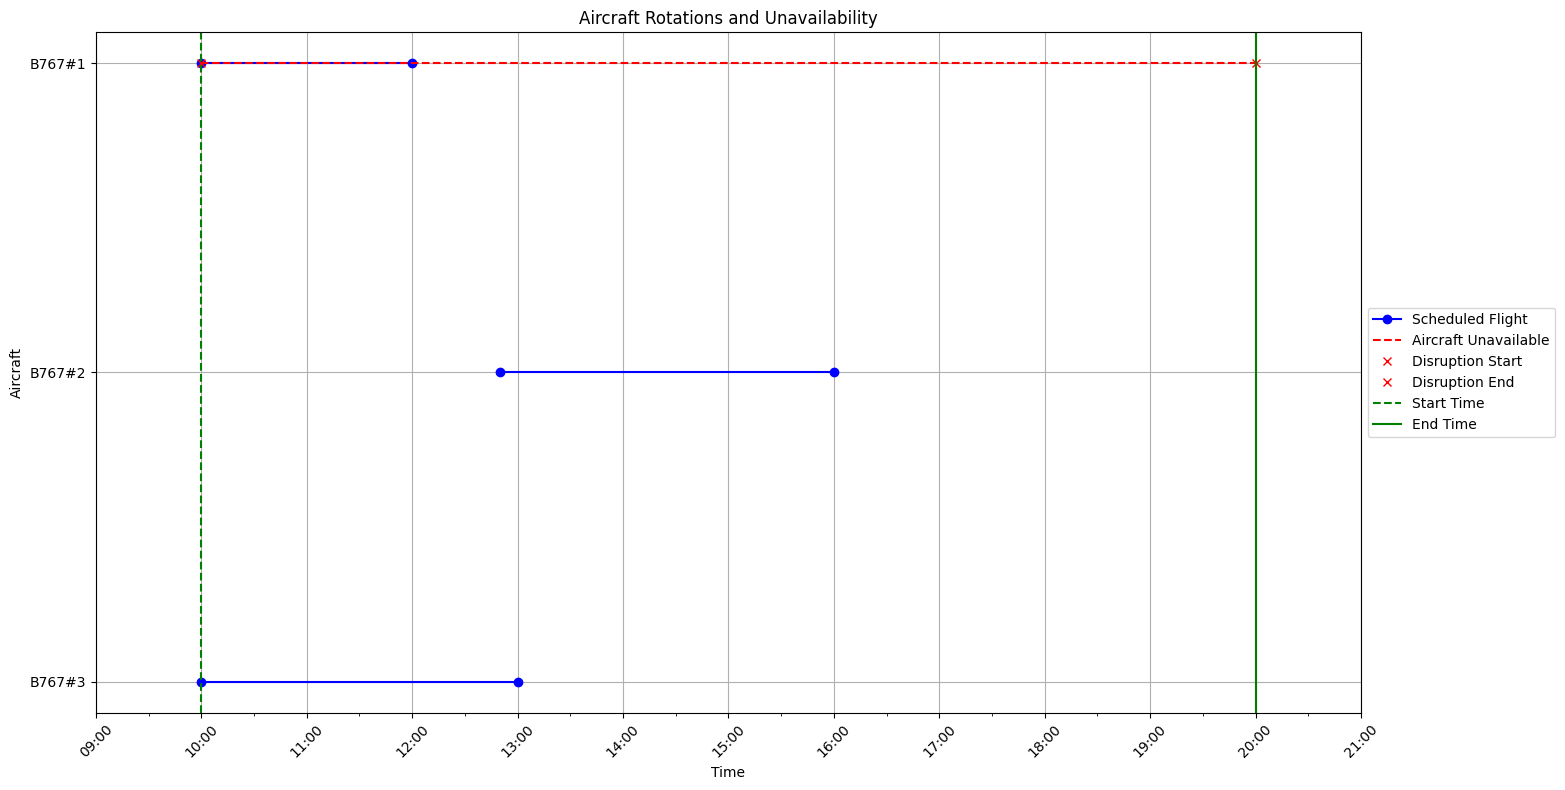

In [1253]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Use the swaps and delays tracked by the environment
swapped_flights = env.swapped_flights
environment_delayed_flights = env.environment_delayed_flights

print("Swapped Flights:", swapped_flights)
print("Environment Delayed Flights:", environment_delayed_flights)

# Create a new rotations_dict to reflect the swaps
updated_rotations_dict = rotations_dict.copy()
for swap in swapped_flights:
    flight_id, new_aircraft_id = swap
    updated_rotations_dict[flight_id]['Aircraft'] = new_aircraft_id

print("Updated Rotations Dict:", updated_rotations_dict)

# Ensure aircraft_indices includes all aircraft
all_aircraft_ids = set([rotation_info['Aircraft'] for rotation_info in updated_rotations_dict.values()]).union(set(aircraft_dict.keys()))
aircraft_ids = sorted(list(all_aircraft_ids), reverse=True)
aircraft_indices = {aircraft_id: index + 1 for index, aircraft_id in enumerate(aircraft_ids)}

print("Aircraft Indices:", aircraft_indices)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Track whether labels have been added to the legend
labels = {
    'Scheduled Flight': False,
    'Swapped Flight': False,
    'Environment Delayed Flight': False,
    'Aircraft Unavailable': False,
    'Disruption Start': False,
    'Disruption End': False,
}

# Plot each flight's schedule based on aircraft
for rotation_id, rotation_info in updated_rotations_dict.items():
    flight_id = rotation_id
    aircraft_id = rotation_info['Aircraft']
    
    if flight_id in flights_dict:
        flight_info = flights_dict[flight_id]
        dep_datetime_str = flight_info['DepTime']
        arr_datetime_str = flight_info['ArrTime']
        
        dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
        arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
        
        # Check if the flight was swapped
        swapped = any(flight_id == swap[0] for swap in swapped_flights)
        delayed = flight_id in environment_delayed_flights
        plot_color = 'green' if swapped else 'orange' if delayed else 'blue'
        plot_label = 'Swapped Flight' if swapped else 'Environment Delayed Flight' if delayed else 'Scheduled Flight'
        
        if (swapped and not labels['Swapped Flight']) or (delayed and not labels['Environment Delayed Flight']) or (not swapped and not delayed and not labels['Scheduled Flight']):
            ax.plot([dep_datetime, arr_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color=plot_color, marker='o', label=plot_label)
            labels[plot_label] = True
        else:
            ax.plot([dep_datetime, arr_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color=plot_color, marker='o')

# Plot disruptions in red for flight delays
if alt_flights_dict:
    for flight_id, disruption_info in alt_flights_dict.items():
        if flight_id in flights_dict:
            dep_datetime_str = flights_dict[flight_id]['DepTime']
            dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
            delay_duration = timedelta(minutes=disruption_info['Delay'])
            delayed_datetime = dep_datetime + delay_duration
            
            aircraft_id = updated_rotations_dict[flight_id]['Aircraft']  # Get the aircraft ID for the flight
            if not labels['Delay of Flight']:
                ax.plot([dep_datetime, delayed_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Delay of Flight')
                labels['Delay of Flight'] = True
            else:
                ax.plot([dep_datetime, delayed_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--')
            if not labels['Disruption Start']:
                ax.plot(dep_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption Start')
                labels['Disruption Start'] = True
            else:
                ax.plot(dep_datetime, aircraft_indices[aircraft_id], 'rx')
            if not labels['Disruption End']:
                ax.plot(delayed_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption End')
                labels['Disruption End'] = True
            else:
                ax.plot(delayed_datetime, aircraft_indices[aircraft_id], 'rx')

# Plot unavailability in red for aircraft
if alt_aircraft_dict:
    for aircraft_id, unavailability_info in alt_aircraft_dict.items():
        start_date = unavailability_info['StartDate']
        start_time = unavailability_info['StartTime']
        end_date = unavailability_info['EndDate']
        end_time = unavailability_info['EndTime']
        
        unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
        
        if aircraft_id in aircraft_indices:  # Ensure the aircraft is in the indices
            print(f"Plotting unavailability for {aircraft_id}")
            if not labels['Aircraft Unavailable']:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Aircraft Unavailable')
                labels['Aircraft Unavailable'] = True
            else:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--')
            if not labels['Disruption Start']:
                ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption Start')
                labels['Disruption Start'] = True
            else:
                ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx')
            if not labels['Disruption End']:
                ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption End')
                labels['Disruption End'] = True
            else:
                ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx')

# Formatting the plot
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Time')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Time')

# Setting the y-ticks to be the indices with corresponding aircraft IDs as labels
plt.yticks(range(1, len(aircraft_ids) + 1), aircraft_ids)

plt.xlabel('Time')
plt.ylabel('Aircraft')
plt.title('Aircraft Rotations and Unavailability')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Create legend on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
